In [1]:
import networkx as nx
import scipy
import time
from tqdm import tqdm
import matplotlib.pyplot as plt 
import numpy as np
from scipy import sparse
import seaborn as sns
import pandas as pd
from random import random
import vapeplot
import math

# Part 1
## 1. Functions to generate the random graphs

In [2]:
def r_regular_graph(degree, K):
    return nx.random_regular_graph(degree, K)

def p_ER(K, p):
    return nx.erdos_renyi_graph(K, p)

## 2. Scripts to check the connectivity of a graph
We wrote a function for each method (**irreducibility**, **eigenvalue** and **bfs**).

In [5]:
def irreducibility(graph):
    A = nx.adjacency_matrix(graph)
    n = len(graph.nodes())
    # Create the S matrix as an identity matrix
    S = scipy.sparse.identity(n)
    # Iterate up to n times
    for i in range(1, n):
        # Update the S matrix
        S += S @ A
        # If the matrix contains all non-zero values return true
        if S.count_nonzero() == n * n:
            return True
    # If after n itaration the S matrix contains zero values return false
    return False

def eigenvalue(graph):
    n = len(graph.nodes())
    # Create the diagonal matrix using the nodes degree
    D = np.zeros((n,n))
    for k, v in (dict(graph.degree())).items():
        D[k][k] = v
    A=nx.adjacency_matrix(graph)
    # Create the Laplacian matrix
    L = D-A
    # Find the eigenvalues of the Laplacian matrix
    eig = np.linalg.eigvals(L)
    # Transform "almost" zero values into zeros 
    tol = 10**(-8)
    eig *= np.abs(eig)>tol
    # Check if the second smallest eigenvalue is greater than 0
    min_eig = np.sort(eig)[1]
    return min_eig>0
         

def bfs(graph):
    node = np.random.randint(1, len(graph.nodes()))
    # List of visited nodes.
    visited = {}
    # Initialize the queue and the visited list
    queue = []
    visited[node] = None
    queue.append(node)
    # Iterate while the queue is not empty 
    while queue:
        s = queue.pop(0)
        # Iterate over the node neighbors
        for neighbor in graph.neighbors(s):
            # If the neighbor is not visited add it in the list and the queue
            if neighbor not in visited:
                visited[neighbor] = None
                queue.append(neighbor)
    # Check if the number of nodes visited is equal to the total number of nodes
    return len(visited) == len(graph.nodes())


We also wrote some additional function used to evaluate the complexity of the different methods.

In [4]:
def compute_time(graph, algo):
    start = time.time()
    algo(graph)
    end = time.time()
    # Return the time difference between the start and the end of the computation
    return(end-start)

def evaluate_time_complexity(k):
    # Store the running time for each algorithm on different graph
    time_algo1=[]
    time_algo2=[]
    time_algo3=[]
    # Evalutate the complexity of the algorithms on ramdom ER graphs with different p values
    for p in np.arange(0.01, 1, 0.01):
        G = p_ER(k, p)
        time_algo1.append(compute_time(G,irreducibility))
        time_algo2.append(compute_time(G,eigenvalue))
        time_algo3.append(compute_time(G,bfs))
    # Return the running times of the 3 algorithms
    return time_algo1, time_algo2, time_algo3

## 3. Compare the complexity of the algorithm to the change of the number of nodes K

In [5]:
# Store the results in a list of pandas DataFrame
dfs = []
# Range of values of K
K = np.arange(100,  501, 50)
# Range of values of p
p = np.arange(  0.01, 1,  0.01)
for k in tqdm(K):
    # Evalutate the complexity of the algorithm for numeber of Nodes = k
    time_algo1, time_algo2, time_algo3 = evaluate_time_complexity(k)
    # Append the result in the DataFrames list
    dfs.append(pd.DataFrame({'method': 'irreducibility', 'time': time_algo1, 'K': k, 'p': p}))
    dfs.append(pd.DataFrame({'method': 'eigenvalue',     'time': time_algo2, 'K': k, 'p': p}))
    dfs.append(pd.DataFrame({'method': 'bfs',            'time': time_algo3, 'K': k, 'p': p}))
# Concatenate all the DataFrames into one
df = pd.concat(dfs)

100%|██████████| 9/9 [03:25<00:00, 22.87s/it]


Plot the results.

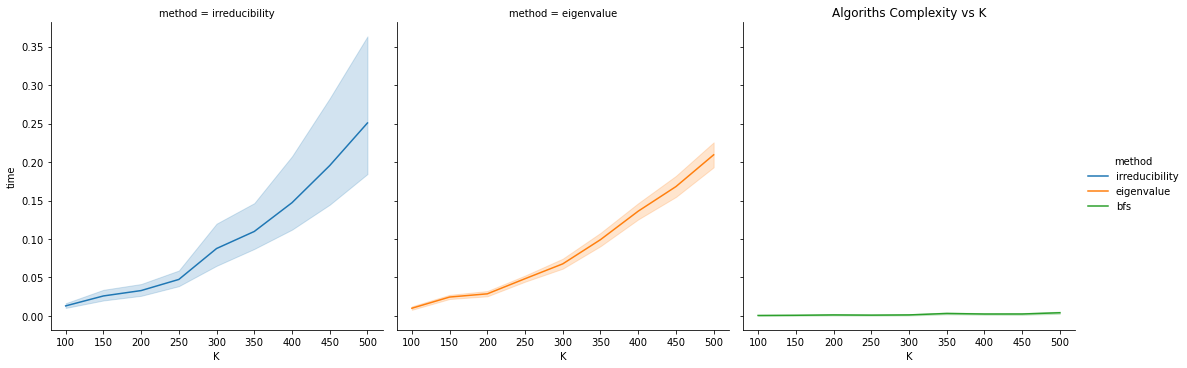

In [6]:
sns.relplot(data=df, x='K', y='time', col='method', palette='tab10', kind="line", hue='method')
plt.title('Algoriths Complexity vs K')
plt.ylabel('time(s)');

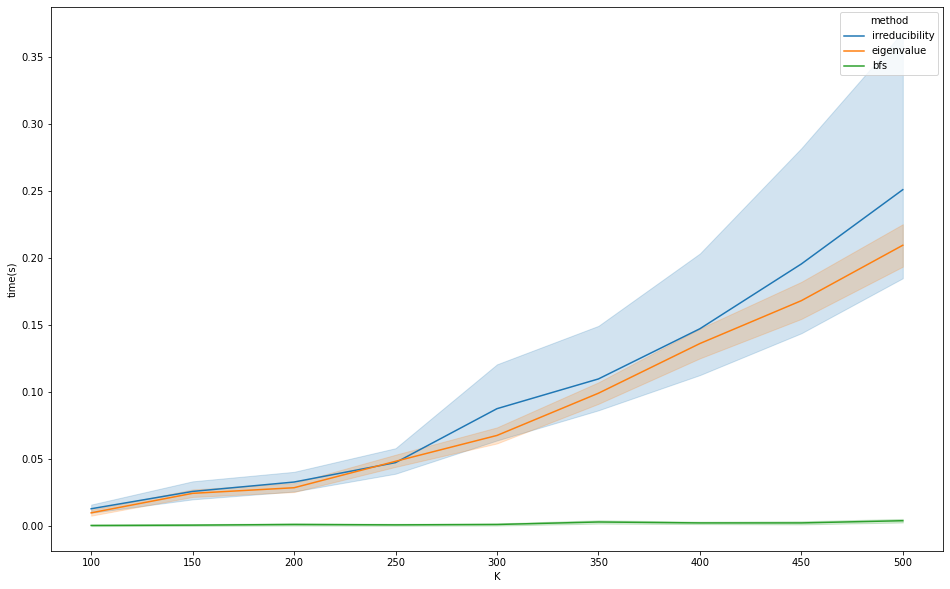

In [7]:
plt.figure(figsize=(16,10))
sns.lineplot(data=df, x='K', y='time', hue='method', palette='tab10')
plt.ylabel('time(s)')
plt.show();

## 4.1 $p_c(\mathcal{G})$ vs $p$ for ER graphs

In [3]:
def monte_carlo_sim_er(n_sim):
    K = 100
    p_conn = []
    P = np.arange(0, 1, .002)
    # For each value of p evaluate the probability pc that the graph is connected
    for p in tqdm(P):
        connect = []
        # Runs n_sim Monte Carlo simulations
        for sim in range(n_sim):
            # Create a random ER graph
            G_ER = p_ER(K, p)
            # Check if it's connected or not
            connect.append(bfs(G_ER))
        # Append the probability that an ER graph with edge prob = p is connected in p_conn
        p_conn.append(sum(connect) / n_sim)
    return P, np.array(p_conn) 

Run the simulations.

In [6]:
p, p_c = monte_carlo_sim_er(250)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [11:03<00:00,  1.33s/it]


Plot the results.

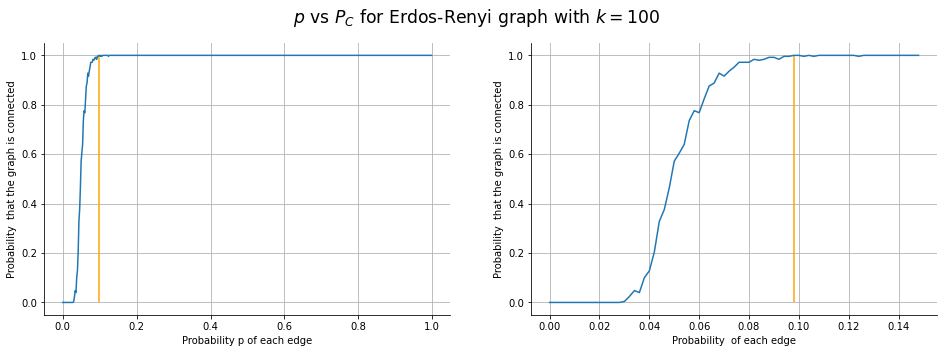

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(16,5))
vapeplot.despine(axs[0])
vapeplot.despine(axs[1])

axs[0].plot(p, p_c)
axs[0].grid(True)
axs[0].vlines(p[(p_c == 1).argmax()], 0, 1, colors='orange')
axs[0].set_xlabel('Probability p of each edge')
axs[0].set_ylabel('Probability  that the graph is connected')
axs[1].plot(p[p<0.15], p_c[p<0.15])
axs[1].grid(True)
axs[1].vlines(p[(p_c == 1).argmax()], 0, 1, colors='orange', label='t')
axs[1].set_xlabel('Probability  of each edge')
axs[1].set_ylabel('Probability  that the graph is connected')
fig.suptitle('$p$ vs $P_C$ for Erdos-Renyi graph with $k=100$', fontsize='xx-large');

## 4.2 $p_c(\mathcal{G})$ vs $K$ for r-regular graphs

In [11]:
def monte_carlo_sim_r_regular(n_sim, rs, max_k, k_step=1):
    dfs = []
    n_iter = 10
    # For each value of r in rs
    for r in rs:
        # Evalutate the probability that the r-regular graph is connected
        for K in tqdm(range(r+1, max_k+1, k_step)):
            prob = []
            # Runs n_iter times the Monte Carlo simulations 
            # in order to get a better view on the variability of the probablity 
            for i in range(n_iter):
                connect = []
                # Runs n_sim simulations and store the probability that the graph is connected in prob
                for sim in range(n_sim):
                    G_r = r_regular_graph(r,K)
                    connect.append(bfs(G_r))
                prob.append(sum(connect) / n_sim)
            # Save the different probs in a DataFrame
            dfs.append(pd.DataFrame({'K': K, 'p_c': prob, 'r': r}))
    return pd.concat(dfs)

Run the simulation.

In [12]:
df = monte_carlo_sim_r_regular(200, [2, 8], max_k=100, k_step=1)

100%|██████████| 92/92 [02:21<00:00,  1.54s/it]


Plot the results.

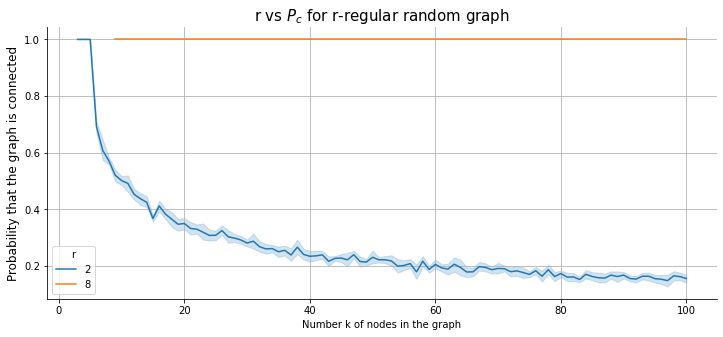

In [14]:
plt.figure(figsize=(12, 5))
vapeplot.despine(plt.axes())
sns.lineplot(data=df, x='K', y='p_c', hue='r', palette='tab10')
plt.grid(True)
plt.ylabel('Probability that the graph is connected', fontsize=12)
plt.xlabel('Number k of nodes in the graph')
plt.title('r vs $P_c$ for r-regular random graph', fontsize=15);

# Part 2
## 1. Write $S$, $N$, $L$ as function of $n$

In [26]:
def N(n):
    return n**3 / 4

def S(n):
    return 5 * n**2 / 4

def L(n):
    return n**3 / 2

## 2. Write the TH as a function of $\bar{h}$ and $n$
We wrote the functions using the formulas provided in the slides.

In [22]:
def h_fat_tree(n):
    return (6*n**3 - 2*n**2 - 4*n - 8) / (n**3 - 4)

def h_r_regular(n):
    r = 4 * n / 5
    Nodes = n**3 / 4
    k = math.ceil(math.log(Nodes - 2*(Nodes-1)/r) / math.log(r-1))
    R = Nodes - 1
    for j in range(1, k):
        R -= r*((r-1)**(j-1))
    h = k*R
    for j in range(1, k):
        h += j*r*((r-1)**(j-1))
    h /= Nodes - 1
    return h

def TH(h, n):
    l = 3 * (n**3) / 4 
    v_f = (n**3) * ((n**3) - 4) / 16
    return l / (h * v_f)

Evaluate the TH values for different values of $n$.

In [32]:
n = np.arange(20, 61, 10, dtype=np.int64)
pd.DataFrame({'n': n, 
              'N': [N(i) for i in n],
              'S': [S(i) for i in n],
              'L': [L(i) for i in n],
              'TH_fat_tree': [TH(h_fat_tree(i), i) for i in n],
              'TH_r_regular': [TH(h_r_regular(i), i) for i in n]})

,n,N,S,L,TH_fat_tree,TH_r_regular
0,20,2000.0,500.0,4000.0,0.000255,0.000524
1,30,6750.0,1125.0,13500.0,0.000075,0.000153
2,40,16000.0,2000.0,32000.0,0.000032,0.000064
3,50,31250.0,3125.0,62500.0,0.000016,0.000033
4,60,54000.0,4500.0,108000.0,0.000009,0.000019


Plot the THs for the diffent types of graph.

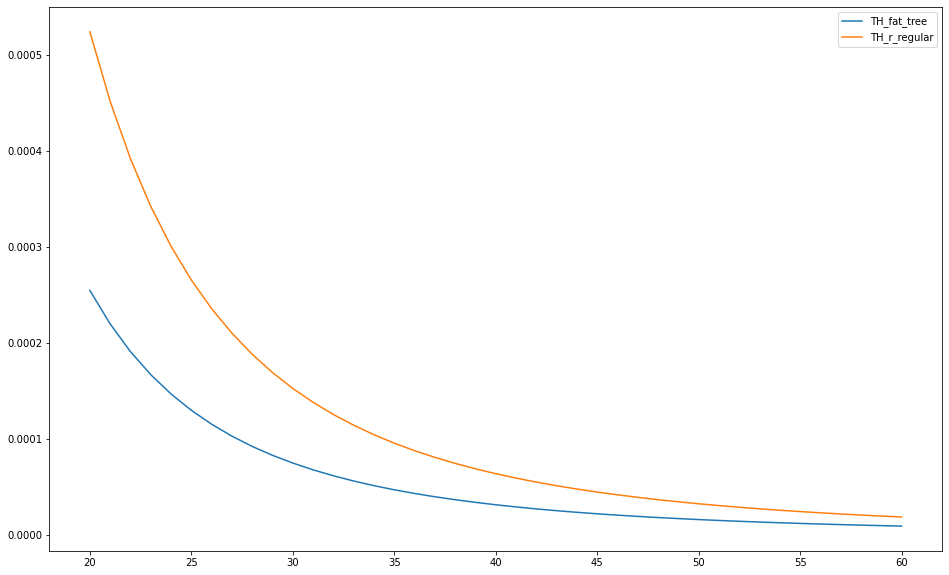

In [23]:
plt.figure(figsize=(16,10))
plt.plot(range(20, 61, 1), [TH(h_fat_tree(n), n) for n in range(20, 61, 1)], label='TH_fat_tree')
plt.plot(range(20, 61, 1), [TH(h_r_regular(n), n) for n in range(20, 61, 1)], label='TH_r_regular')
plt.legend();